# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [6]:
df.sentiment.value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


*найбільше нейтрально забарвлених текстів, а вже негативних чи позитивних майже однакова кількість*

<Axes: >

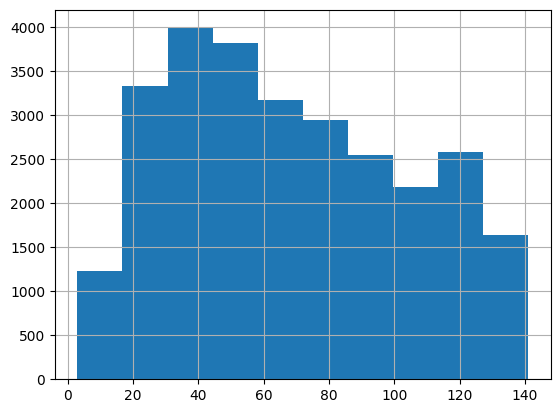

In [15]:
df.text.str.len().hist()

*з гістограми видно, що найбільше текстів довжиною від 35 до майже 60 - середні речення*

*наступні по частоті теж короткі тексти, але всеодно найменше дуже коротких текстів або дуже довгих*

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [31]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import PunktSentenceTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
english_stopwords = stopwords.words('english')

In [23]:
stemmer = SnowballStemmer('english')

In [25]:
sent_tok = PunktSentenceTokenizer()

In [32]:
def tokenize(text: str):
    tokens = []
    for s in sent_tok.tokenize(text):
        s = s.lower()
        s = re.sub(r'[^a-z]+', ' ', s)
        words = s.split()
        for w in words:
            if w in english_stopwords or len(w) < 2:
                continue
            tokens.append(stemmer.stem(w)) # 4) стеммінг
    return tokens

In [33]:
vectorizer = CountVectorizer(tokenizer=tokenize, lowercase=False, max_features=5000)
inputs = vectorizer.fit_transform(df.text)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [34]:
inputs.shape

(27480, 5000)

In [35]:
from sklearn.model_selection import train_test_split

In [37]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs,
                                                            df.sentiment,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=df.sentiment)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [41]:
model_lr = LogisticRegression()
model_lr.fit(X_train_bow,y_train)
y_pred_lr = model_lr.predict(X_test_bow)
acc_lr = accuracy_score(y_test, y_pred_lr)

In [42]:
acc_lr

0.6866812227074236

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_bow,y_train)
y_pred_dt = model_dt.predict(X_test_bow)
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_dt

0.6419213973799127

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_bow,y_train)
y_pred_rf = model_rf.predict(X_test_bow)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_rf

0.6899563318777293

In [48]:
print(f"=== LogisticRegression ===\n",classification_report(y_test, y_pred_lr))
print(f"=== DecisionTree ===\n",classification_report(y_test, y_pred_dt))
print(f"=== RandomForest ===\n",classification_report(y_test, y_pred_rf))

=== LogisticRegression ===
               precision    recall  f1-score   support

    negative       0.70      0.63      0.67      1556
     neutral       0.63      0.71      0.67      2223
    positive       0.76      0.70      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496

=== DecisionTree ===
               precision    recall  f1-score   support

    negative       0.61      0.64      0.62      1556
     neutral       0.63      0.60      0.61      2223
    positive       0.68      0.70      0.69      1717

    accuracy                           0.64      5496
   macro avg       0.64      0.65      0.64      5496
weighted avg       0.64      0.64      0.64      5496

=== RandomForest ===
               precision    recall  f1-score   support

    negative       0.69      0.63      0.66      1556
     neutral       0.66      0.68      0.67      2223
   

*загалом непогано, найкраще себе показала логістична регресія якщо дивитись на f1-score, бо accuracy і логістичній і рандом форест майже однакова*

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [51]:
words = vectorizer.get_feature_names_out()

coefs = model_lr.coef_
classes = model_lr.classes_

coef_df = pd.DataFrame(coefs.T, index=words, columns=classes)

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model